# 온라인 스토어 유저 데이터 EDA
## 데이터 설명
- `2020-09-24 ~ 2020-12-21`에 걸쳐 일어난 온라인 스토어 유저 데이터
- 컬럼 설명
    - `event_time` : 이벤트 발생 시간 로그
    - `month` : 이벤트 발생 월
    - `day` : 이벤트 발생 일
    - `day_name` : 이벤트 발생 요일
    - `hour` : 이벤트 발생 시간
    - `event_type` : 발생한 이벤트 (view, cart, purchase)
    - `product_id` : 제품 id
    - `category_id` : 제품이 속한 카테고리 id
    - `category_code` : 제품이 속한 카테고리 코드
    - `price` : 가격
    - `user_id` : 로그인한 유저 id
    - `user_session` : 유저가 활동한 세션
    - `cat_code_1` : 대분류
    - `cat_code_2` : 중분류
    - `cat_code_3` : 소분류

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta
import missingno as msno

In [2]:
original_path = "data/events.csv"
file_path = "data/df_preprocessed.csv"
original_df = pd.read_csv(original_path)
df = pd.read_csv(file_path)
# df.drop(['index'], axis = 1, inplace = True)
df.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,pitatel,31.9,1.520000e+18,LJuJVLEjPT,electronics,telephone,no_cat
1,2020-09-24 13:58:51+00:00,9,24,Thursday,13,view,790590,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,IBu02xVrhQ,computers,notebook,no_cat
2,2020-09-24 14:00:24+00:00,9,24,Thursday,14,view,790590,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,l68Br3I0Tl,computers,notebook,no_cat
3,2020-09-25 08:36:13+00:00,9,25,Friday,8,view,751693,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,6fTFbeiEqq,computers,notebook,no_cat
4,2020-09-30 16:16:16+00:00,9,30,Wednesday,16,view,751693,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,poHN5cBucr,computers,notebook,no_cat


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407913 entries, 0 to 407912
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     407913 non-null  object 
 1   month          407913 non-null  int64  
 2   day            407913 non-null  int64  
 3   day_name       407913 non-null  object 
 4   hour           407913 non-null  int64  
 5   event_type     407913 non-null  object 
 6   product_id     407913 non-null  int64  
 7   category_id    407913 non-null  float64
 8   category_code  407913 non-null  object 
 9   brand          407913 non-null  object 
 10  price          407913 non-null  float64
 11  user_id        407913 non-null  float64
 12  user_session   407913 non-null  object 
 13  cat_code_1     407913 non-null  object 
 14  cat_code_2     407913 non-null  object 
 15  cat_code_3     407913 non-null  object 
dtypes: float64(3), int64(4), object(9)
memory usage: 49.8+ MB


In [4]:
# 결측치 확인
df.isnull().sum()

event_time       0
month            0
day              0
day_name         0
hour             0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
cat_code_1       0
cat_code_2       0
cat_code_3       0
dtype: int64

### `.describe()` 확인
- `price` 컬럼 평균 약 125.67인 것에 비해, max 값이 약 64771
    - 이상치가 크다
- `event_type` 컬럼 가장 많은 값 `view`
- `category_code` 컬럼 가장 많은 값 `electronics.telephone`
- `brand` 컬럼 가장 많은 값 `samsung`
- `user_session` 컬럼 `count`는 407913 인 것에 비해 `unique`는 234135
    - `user_session` 여러개 잡힌 사람들 존재
    - 가장 오래 활동한 `user_session : 9HqvxzKlPb`

In [5]:
df.describe()

,month,day,hour,product_id,category_id,price,user_id
count,407913.000000,407913.000000,407913.000000,4.079130e+05,4.079130e+05,407913.000000,4.079130e+05
mean,10.770439,15.558948,12.352386,1.883717e+06,2.140011e+18,125.672520,1.520000e+18
std,0.854003,8.603416,5.404243,1.425949e+06,8.122978e+14,313.322016,8.678923e+06
min,9.000000,1.000000,0.000000,8.540000e+02,2.140000e+18,0.900000,1.520000e+18
25%,10.000000,8.000000,8.000000,7.431800e+05,2.140000e+18,25.860000,1.520000e+18
50%,11.000000,16.000000,12.000000,1.443880e+06,2.140000e+18,58.780000,1.520000e+18
75%,11.000000,23.000000,17.000000,3.658540e+06,2.140000e+18,146.920000,1.520000e+18
max,12.000000,31.000000,23.000000,4.183872e+06,2.230000e+18,64771.060000,1.520000e+18


In [6]:
df.describe(include="object")

,event_time,day_name,event_type,category_code,brand,user_session,cat_code_1,cat_code_2,cat_code_3
count,407913,407913,407913,407913,407913,407913,407913,407913,407913
unique,392324,7,3,107,945,234135,14,42,78
top,2020-12-19 22:05:25+00:00,Monday,view,electronics.telephone,samsung,9HqvxzKlPb,computers,components,no_cat
freq,10,64724,367166,63645,15203,424,164793,79230,153112


### 오리지널 데이터셋과 전처리 거친 데이터셋 컬럼 비교
- 결측치 발견되었던 `category_code`, `brand` 컬럼 비율을 비교해본다

In [7]:
# 오리지널 데이터셋 category_code 비율 TOP 15
ori_cat = original_df["category_code"].value_counts(normalize=True)[:15]
ori_cat_df = pd.DataFrame({"ori_cat_code" : ori_cat}).reset_index()
ori_cat_df

,category_code,ori_cat_code
0,electronics.telephone,0.143986
1,computers.peripherals.printer,0.079135
2,computers.components.videocards,0.077924
3,stationery.cartrige,0.072676
4,electronics.audio.acoustic,0.044925
5,computers.notebook,0.044063
6,computers.components.cpu,0.041934
7,computers.components.motherboard,0.041357
8,electronics.video.tv,0.035294
9,electronics.tablet,0.033637


In [8]:
# 전처리 거친 데이터셋 category_code 비율 TOP 15
preprocessed_cat = df["category_code"].value_counts(normalize=True)[:15]
preprocessed_cat_df = pd.DataFrame({"preprocessed_cat_code" : preprocessed_cat}).reset_index()
preprocessed_cat_df

,category_code,preprocessed_cat_code
0,electronics.telephone,0.156026
1,computers.peripherals.printer,0.076543
2,stationery.cartrige,0.073567
3,computers.components.videocards,0.065173
4,computers.notebook,0.052288
5,electronics.audio.acoustic,0.048275
6,electronics.tablet,0.037741
7,computers.components.cpu,0.036579
8,computers.components.motherboard,0.036172
9,electronics.video.tv,0.032561


In [9]:
# 오리지널 데이터셋 brand 비율 TOP 35
ori_brand = original_df["brand"].value_counts(normalize=True)[:35]
ori_brand_df = pd.DataFrame({"ori_brand" : ori_brand}).reset_index()
ori_brand_df

,brand,ori_brand
0,samsung,0.036109
1,amd,0.032861
2,asus,0.031627
3,canon,0.031516
4,gigabyte,0.023102
5,hp,0.019877
6,panasonic,0.019551
7,sirius,0.019117
8,pioneer,0.019040
9,msi,0.016268


In [10]:
# 전처리 거친 데이터셋 category_code 비율 TOP 35
preprocessed_brand = df["brand"].value_counts(normalize=True)[:35]
preprocessed_brand_df = pd.DataFrame({"preprocessed_brand" : preprocessed_brand}).reset_index()
preprocessed_brand_df

,brand,preprocessed_brand
0,samsung,0.037270
1,amd,0.029582
2,sirius,0.029041
3,asus,0.029026
4,canon,0.027763
5,hp,0.021387
6,gigabyte,0.020970
7,palit,0.018548
8,palmexx,0.018528
9,pioneer,0.017389


In [11]:
# category_code Top 15가 오리지널 데이터셋에서 차지하는 비율 : 71%
print("category_code Top 15가 오리지널 데이터셋에서 차지하는 비율 :", round(np.sum(ori_cat_df["ori_cat_code"]) * 100), "%")

category_code Top 15가 오리지널 데이터셋에서 차지하는 비율 : 71 %


In [12]:
# category_code Top 15가 전처리 거친 데이터셋에서 차지하는 비율 : 71%
print("category_code Top 15가 전처리 거친 데이터셋에서 차지하는 비율 :", round(np.sum(preprocessed_cat_df["preprocessed_cat_code"]) * 100), "%")

category_code Top 15가 전처리 거친 데이터셋에서 차지하는 비율 : 71 %


In [13]:
# brand Top 15가 오리지널 데이터셋에서 차지하는 비율 : 71%
print("brand Top 15가 오리지널 데이터셋에서 차지하는 비율 :", round(np.sum(ori_brand_df["ori_brand"]) * 100), "%")

brand Top 15가 오리지널 데이터셋에서 차지하는 비율 : 51 %


In [14]:
# brand Top 15가 전처리 거친 데이터셋에서 차지하는 비율 : 71%
print("brand Top 15가 전처리 거친 데이터셋에서 차지하는 비율 :", round(np.sum(preprocessed_brand_df["preprocessed_brand"]) * 100), "%")

brand Top 15가 전처리 거친 데이터셋에서 차지하는 비율 : 51 %


#### 시각화 (오리지널, 전처리)

In [15]:
# 오리지널, 전처리 거친 데이터셋 category_code Top 15 비교 위해 두 데이터셋 합친 데이터프레임 새로 생성
feature_contrast = pd.merge(ori_cat, preprocessed_cat, how="inner", on="category_code")
feature_contrast.columns = ["original_rate", "preprocessed_rate"]
# feature_contrast = feature_contrast.sort_values(by="original_rate")
feature_contrast


,original_rate,preprocessed_rate
category_code,,
electronics.telephone,0.143986,0.156026
computers.peripherals.printer,0.079135,0.076543
computers.components.videocards,0.077924,0.065173
stationery.cartrige,0.072676,0.073567
electronics.audio.acoustic,0.044925,0.048275
computers.notebook,0.044063,0.052288
computers.components.cpu,0.041934,0.036579
computers.components.motherboard,0.041357,0.036172
electronics.video.tv,0.035294,0.032561


In [16]:
# 오리지널, 전처리 거친 데이터셋 brand Top 35 비교 위해 두 데이터셋 합친 데이터프레임 새로 생성
feature_contrast_br = pd.merge(ori_brand, preprocessed_brand, how="inner", on="brand")
feature_contrast_br.columns = ["original_rate", "preprocessed_rate"]
# feature_contrast_br = feature_contrast_br.sort_values(by="original_rate")
feature_contrast_br


,original_rate,preprocessed_rate
brand,,
samsung,0.036109,0.037270
amd,0.032861,0.029582
asus,0.031627,0.029026
canon,0.031516,0.027763
gigabyte,0.023102,0.020970
hp,0.019877,0.021387
panasonic,0.019551,0.016464
sirius,0.019117,0.029041
pioneer,0.019040,0.017389


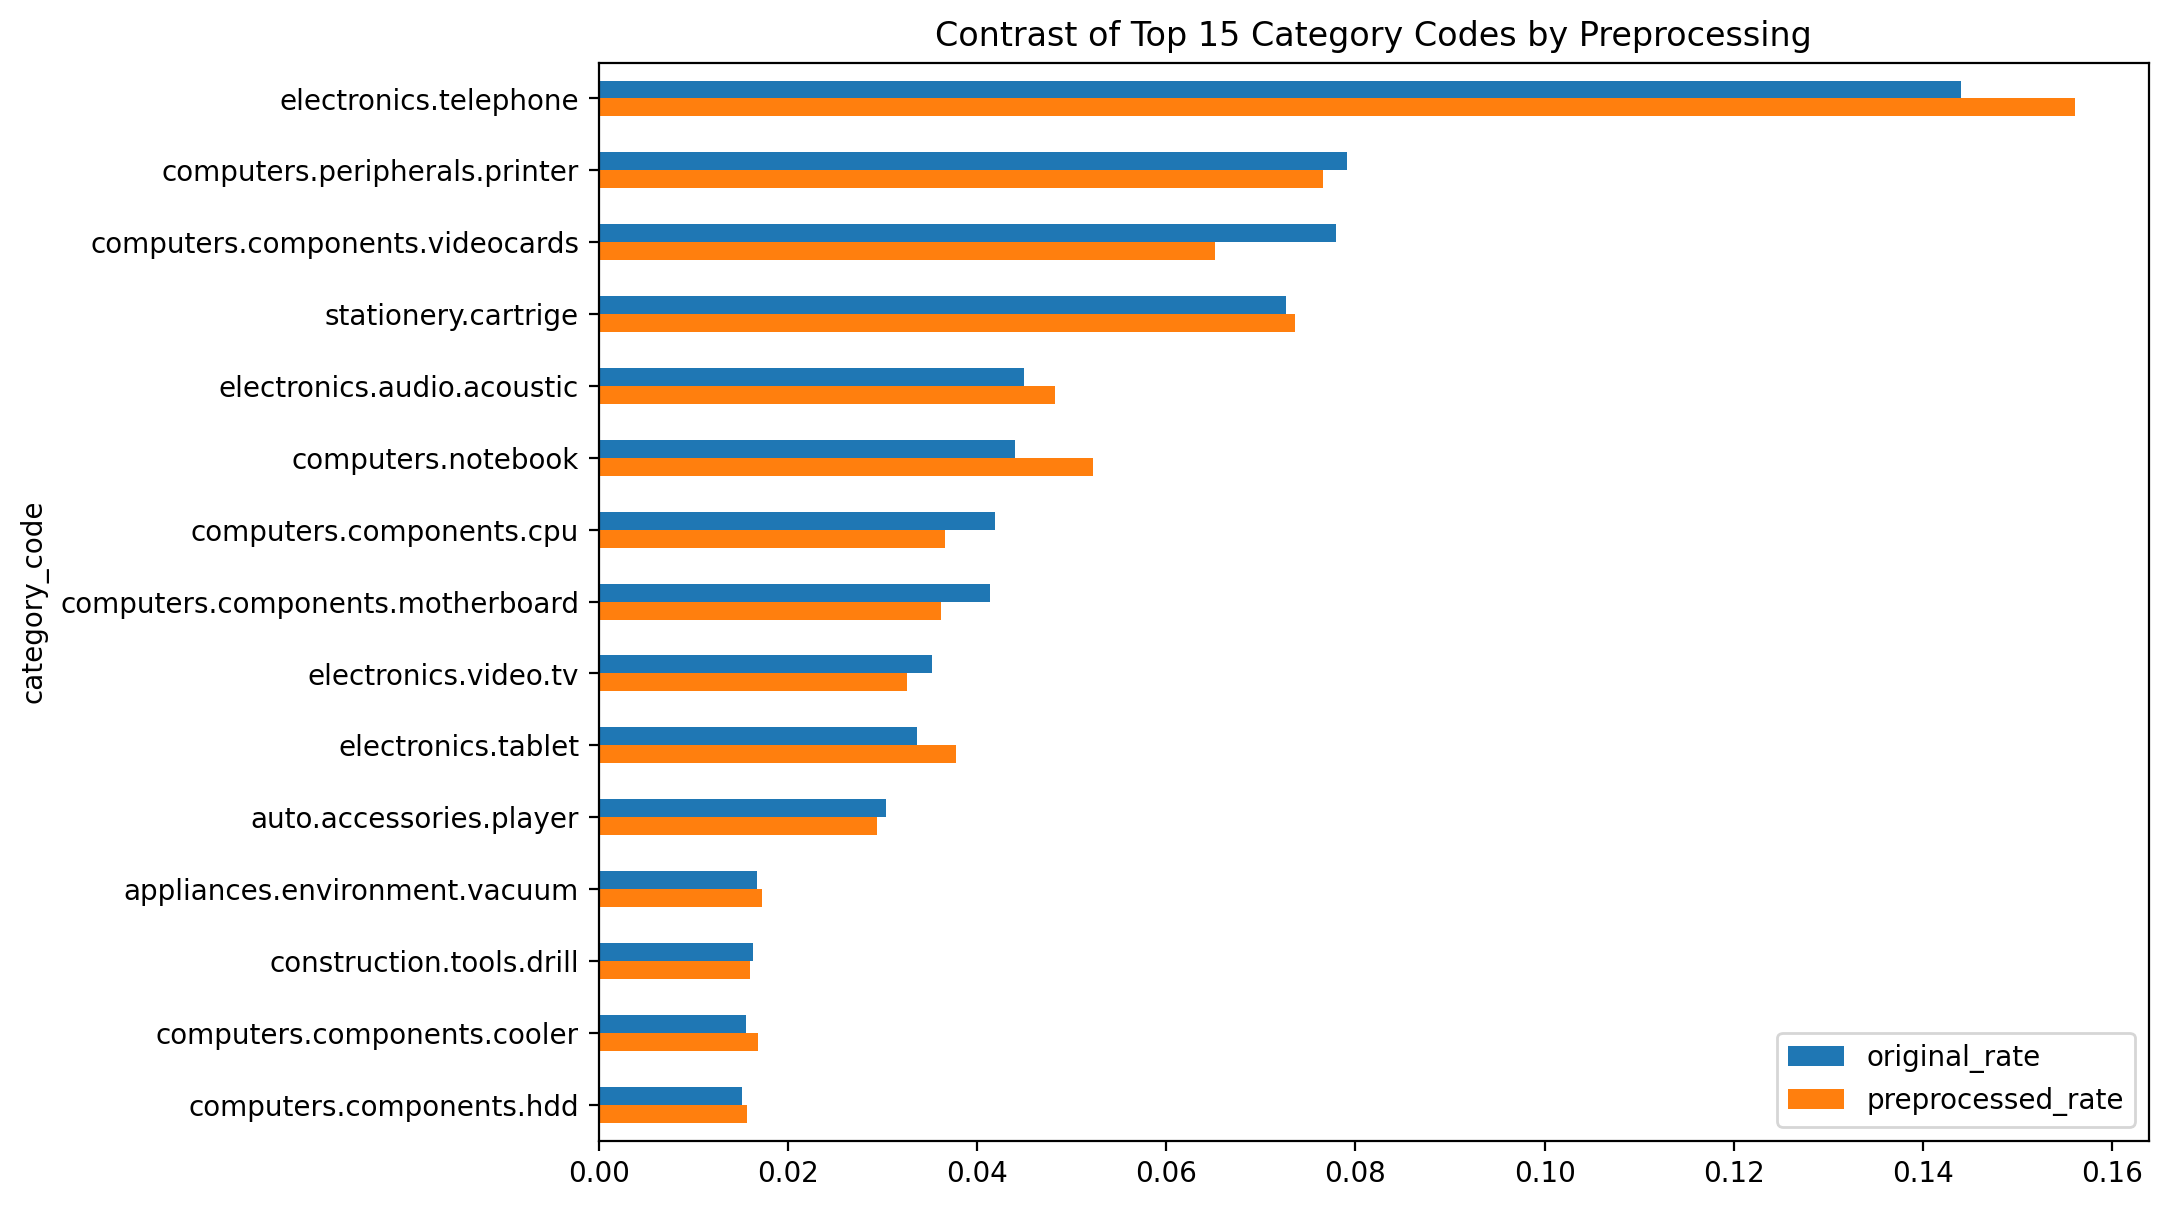

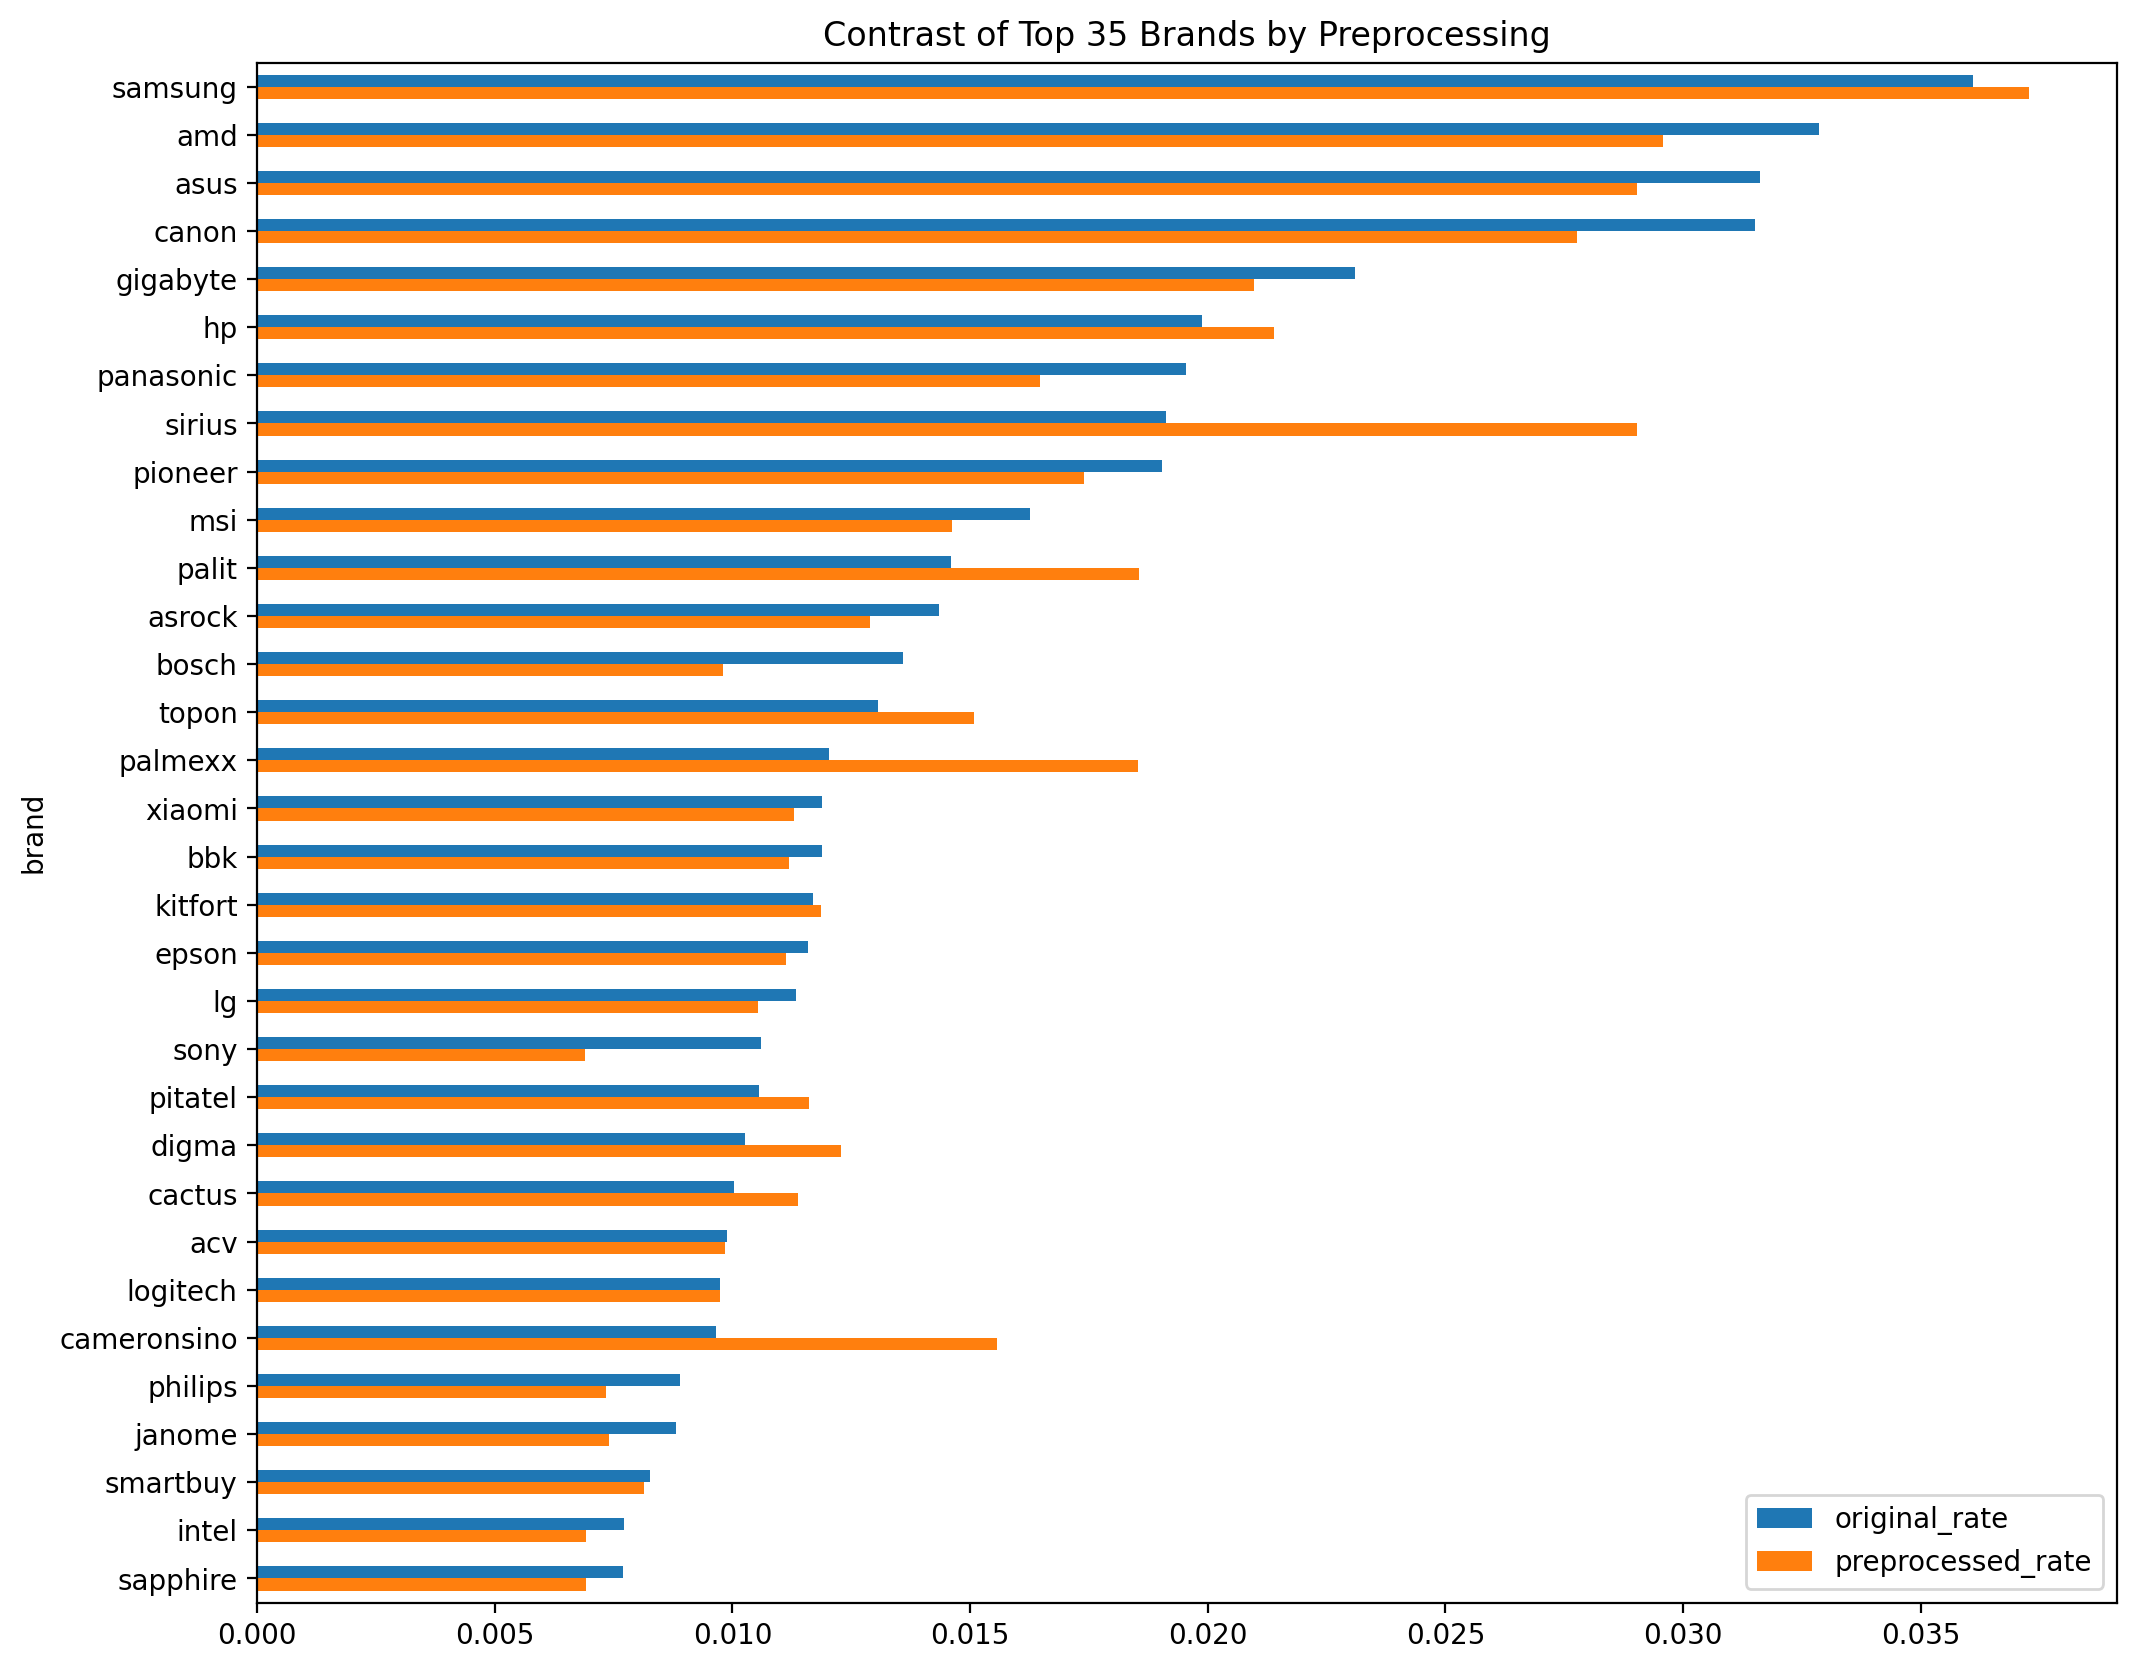

In [32]:
# 오리지널, 전처리 거친 데이터셋 category_code Top 15 비교 시각화
# 오리지널, 전처리 거친 데이터셋 brand Top 35 비교 시각화

f1 = feature_contrast.plot.barh(figsize=(10, 7))
f2 = feature_contrast_br.plot.barh(figsize=(12, 10))

f1.set_title("Contrast of Top 15 Category Codes by Preprocessing")
f2.set_title("Contrast of Top 35 Brands by Preprocessing")

f1.invert_yaxis()
f2.invert_yaxis()

In [18]:
# 오리지날, 전처리 후 브랜드 비율 차이 크게 나는 것들 자세히 비교
# 차이나는 비율이 엄청 크지는 않다

# 브랜드들 검색 조건
# sirius, palit, palmexx, cameronsino
or_br_contrast_cond = (ori_brand_df["brand"] == "sirius") | (ori_brand_df["brand"] == "palit") | (ori_brand_df["brand"] == "palmexx") | (ori_brand_df["brand"] == "cameronsino")

pre_br_contrast_cond = (preprocessed_brand_df["brand"] == "sirius") | (preprocessed_brand_df["brand"] == "palit") | (preprocessed_brand_df["brand"] == "palmexx") | (preprocessed_brand_df["brand"] == "cameronsino")

# 브랜드 검색 조건으로 필터링한 데이터프레임들 merge해서 새로운 데이터프레임 생성
diff_df = pd.merge(ori_brand_df[or_br_contrast_cond], preprocessed_brand_df[pre_br_contrast_cond])

# 전처리한 데이터 - 오리지널 데이터 빼서 차이 확인
diff_df["difference"] = diff_df["preprocessed_brand"] - diff_df["ori_brand"]
diff_df

,brand,ori_brand,preprocessed_brand,difference
0,sirius,0.019117,0.029041,0.009923
1,palit,0.014608,0.018548,0.003940
2,palmexx,0.012032,0.018528,0.006497
3,cameronsino,0.009662,0.015557,0.005895


- 전처리 한 컬럼 시각화 결과, 오리지널 데이터와 크게 차이나지 않는 것 확인

### 이상치 확인

In [19]:
df[df.category_code == "electronics.telephone"].describe()

,month,day,hour,product_id,category_id,price,user_id
count,63645.000000,63645.000000,63645.000000,6.364500e+04,6.364500e+04,63645.000000,6.364500e+04
mean,10.739555,15.490848,12.310614,2.342269e+06,2.140000e+18,68.177481,1.520000e+18
std,0.850167,8.635620,5.455147,1.352118e+06,3.963856e+13,133.443476,6.479411e+05
min,9.000000,1.000000,0.000000,8.540000e+02,2.140000e+18,1.570000,1.520000e+18
25%,10.000000,8.000000,8.000000,1.153852e+06,2.140000e+18,16.510000,1.520000e+18
50%,11.000000,16.000000,12.000000,1.812603e+06,2.140000e+18,29.680000,1.520000e+18
75%,11.000000,22.000000,17.000000,3.828043e+06,2.140000e+18,61.100000,1.520000e+18
max,12.000000,31.000000,23.000000,4.183870e+06,2.150000e+18,1790.030000,1.520000e+18


In [20]:
df[(df.category_code == "electronics.telephone") & (df.price >= 1790)]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
339911,2020-09-28 23:57:10+00:00,9,28,Monday,23,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,CyjmerMc3I,electronics,telephone,no_cat
339912,2020-09-29 16:29:50+00:00,9,29,Tuesday,16,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,kiLi35onu9,electronics,telephone,no_cat
339913,2020-10-06 04:31:23+00:00,10,6,Tuesday,4,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,VWv8RTZuHA,electronics,telephone,no_cat
339914,2020-10-08 03:34:06+00:00,10,8,Thursday,3,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,uSNPJdfSEV,electronics,telephone,no_cat
339915,2020-10-11 04:38:32+00:00,10,11,Sunday,4,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,RJw9AOiLiW,electronics,telephone,no_cat
339916,2020-10-11 04:39:00+00:00,10,11,Sunday,4,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,RJw9AOiLiW,electronics,telephone,no_cat
339917,2020-10-27 13:40:18+00:00,10,27,Tuesday,13,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,UyowYgd8qi,electronics,telephone,no_cat
339918,2020-11-07 12:50:22+00:00,11,7,Saturday,12,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,acTfIF225C,electronics,telephone,no_cat
339919,2020-11-08 08:39:48+00:00,11,8,Sunday,8,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,7Mgk9nKqve,electronics,telephone,no_cat
339920,2020-11-09 02:33:19+00:00,11,9,Monday,2,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,Xh49RwBNrm,electronics,telephone,no_cat


In [21]:
df[(df.brand == "apple")]["category_code"].value_counts()

category_code
computers.notebook                      274
electronics.tablet                      121
computers.peripherals.printer            90
computers.peripherals.keyboard           24
electronics.audio.headphone              19
electronics.video.tv                     13
computers.peripherals.mouse              10
computers.components.network_adapter      9
computers.peripherals.camera              7
stationery.cartrige                       3
construction.tools.saw                    2
electronics.audio.acoustic                1
electronics.telephone                     1
Name: count, dtype: int64

In [22]:
# df[(df.category_code == "electronics.telephone") & (df.price >= 1790)]
df[(df.category_code == "electronics.telephone") & (df.brand == "apple")]


,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
322479,2020-12-05 17:53:04+00:00,12,5,Saturday,17,view,4099105,2.140000e+18,electronics.telephone,apple,52.44,1.520000e+18,eCLXAyOWTM,electronics,telephone,no_cat


In [23]:
df[df.brand == "samsung"].describe()

,month,day,hour,product_id,category_id,price,user_id
count,15203.000000,15203.000000,15203.000000,1.520300e+04,1.520300e+04,15203.000000,1.520300e+04
mean,10.761166,15.607183,12.341972,2.198652e+06,2.140000e+18,201.819262,1.520000e+18
std,0.850013,8.572904,5.513311,1.331812e+06,4.574870e+05,816.583106,3.404912e+04
min,9.000000,1.000000,0.000000,4.220000e+03,2.140000e+18,1.570000,1.520000e+18
25%,10.000000,8.000000,8.000000,9.575860e+05,2.140000e+18,21.630000,1.520000e+18
50%,11.000000,16.000000,12.000000,1.814282e+06,2.140000e+18,57.620000,1.520000e+18
75%,11.000000,23.000000,17.000000,3.642317e+06,2.140000e+18,205.490000,1.520000e+18
max,12.000000,31.000000,23.000000,4.183836e+06,2.140000e+18,42590.130000,1.520000e+18


In [24]:
df[df.cat_code_1 == "computers"].describe()

,month,day,hour,product_id,category_id,price,user_id
count,164793.000000,164793.000000,164793.000000,1.647930e+05,1.647930e+05,164793.000000,1.647930e+05
mean,10.805562,15.520162,12.405994,1.876205e+06,2.140005e+18,154.170638,1.520000e+18
std,0.860274,8.565946,5.405063,1.475307e+06,3.807996e+14,356.533499,2.222087e+06
min,9.000000,1.000000,0.000000,1.357000e+03,2.140000e+18,1.570000,1.520000e+18
25%,10.000000,8.000000,8.000000,6.823210e+05,2.140000e+18,31.750000,1.520000e+18
50%,11.000000,16.000000,12.000000,1.355099e+06,2.140000e+18,77.730000,1.520000e+18
75%,11.000000,22.000000,17.000000,3.790736e+06,2.140000e+18,204.290000,1.520000e+18
max,12.000000,31.000000,23.000000,4.183872e+06,2.220000e+18,64771.060000,1.520000e+18


In [25]:
df.select_dtypes(include=np.number).columns.tolist()

['month', 'day', 'hour', 'product_id', 'category_id', 'price', 'user_id']

c:\Users\aryij\anaconda3\envs\multi_cat\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aryij\anaconda3\envs\multi_cat\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aryij\anaconda3\envs\multi_cat\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


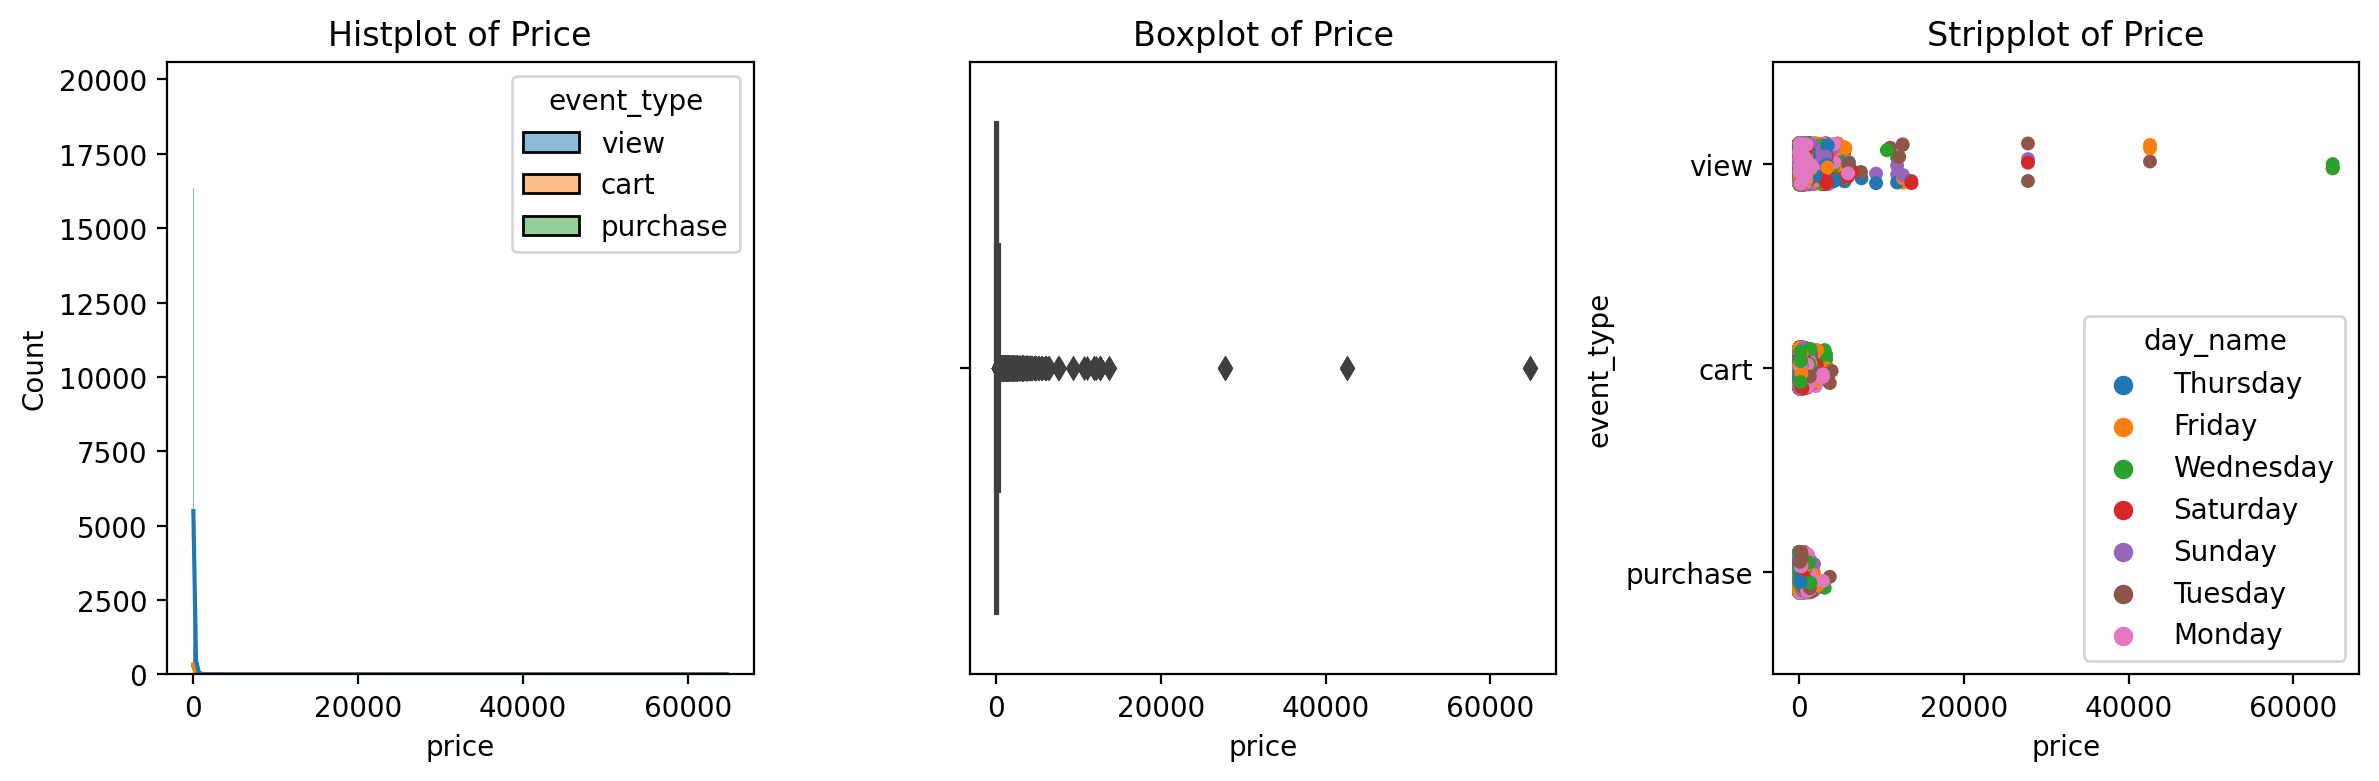

In [26]:
nrows, ncols = 1, 3
_, axes = plt.subplots(nrows, ncols, figsize=(12, 4))

p1 = sns.histplot(data=df, x="price", kde=True, hue="event_type", ax=axes[0])
p2 = sns.boxplot(data=df, x="price", hue="event_type", ax=axes[1])
# p3 = sns.stripplot(data=df, x="event_type", y="price", hue="day_name", ax=axes[2])
p3 = sns.stripplot(data=df, x="price", y="event_type", hue="day_name", ax=axes[2])

p1.set_title("Histplot of Price")
p2.set_title("Boxplot of Price")
p3.set_title("Stripplot of Price")

plt.tight_layout()
plt.show()

In [27]:
# https://bigdaheta.tistory.com/82
QR1 = df[["price"]].quantile(q=0.25)
QR3 = df[["price"]].quantile(q=0.75)
print(QR1) 
print(QR3)

price    25.86
Name: 0.25, dtype: float64
price    146.92
Name: 0.75, dtype: float64


In [28]:
IQR = QR3-QR1
IQR

price    121.06
dtype: float64

In [29]:
IQR_df = df[(df['price'] <= QR3['price']+1.5*IQR['price']) & (df['price'] >= QR1['price']-1.5*IQR['price'])]
IQR_df

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,pitatel,31.90,1.520000e+18,LJuJVLEjPT,electronics,telephone,no_cat
1,2020-09-24 13:58:51+00:00,9,24,Thursday,13,view,790590,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,IBu02xVrhQ,computers,notebook,no_cat
2,2020-09-24 14:00:24+00:00,9,24,Thursday,14,view,790590,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,l68Br3I0Tl,computers,notebook,no_cat
3,2020-09-25 08:36:13+00:00,9,25,Friday,8,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,6fTFbeiEqq,computers,notebook,no_cat
4,2020-09-30 16:16:16+00:00,9,30,Wednesday,16,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,poHN5cBucr,computers,notebook,no_cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407902,2020-12-21 09:32:28+00:00,12,21,Monday,9,view,905345,2.140000e+18,computers.peripherals.mouse,logitech,103.46,1.520000e+18,y24eJpmfbj,computers,peripherals,mouse
407909,2020-12-21 13:46:48+00:00,12,21,Monday,13,view,1012989,2.140000e+18,electronics.video.tv,hyundai,126.03,1.520000e+18,5ZMDadMXkO,electronics,video,tv
407910,2020-12-21 15:31:58+00:00,12,21,Monday,15,view,3605780,2.140000e+18,accessories.bag,thermos,8.81,1.520000e+18,PYjvdxNImA,accessories,bag,no_cat
407911,2020-12-21 16:11:25+00:00,12,21,Monday,16,view,1652970,2.140000e+18,electronics.video.tv,samsung,297.37,1.520000e+18,CICmjyK027,electronics,video,tv


c:\Users\aryij\anaconda3\envs\multi_cat\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aryij\anaconda3\envs\multi_cat\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aryij\anaconda3\envs\multi_cat\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\aryij\AppData\Local\Temp\ipykernel_5620\686392024.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.

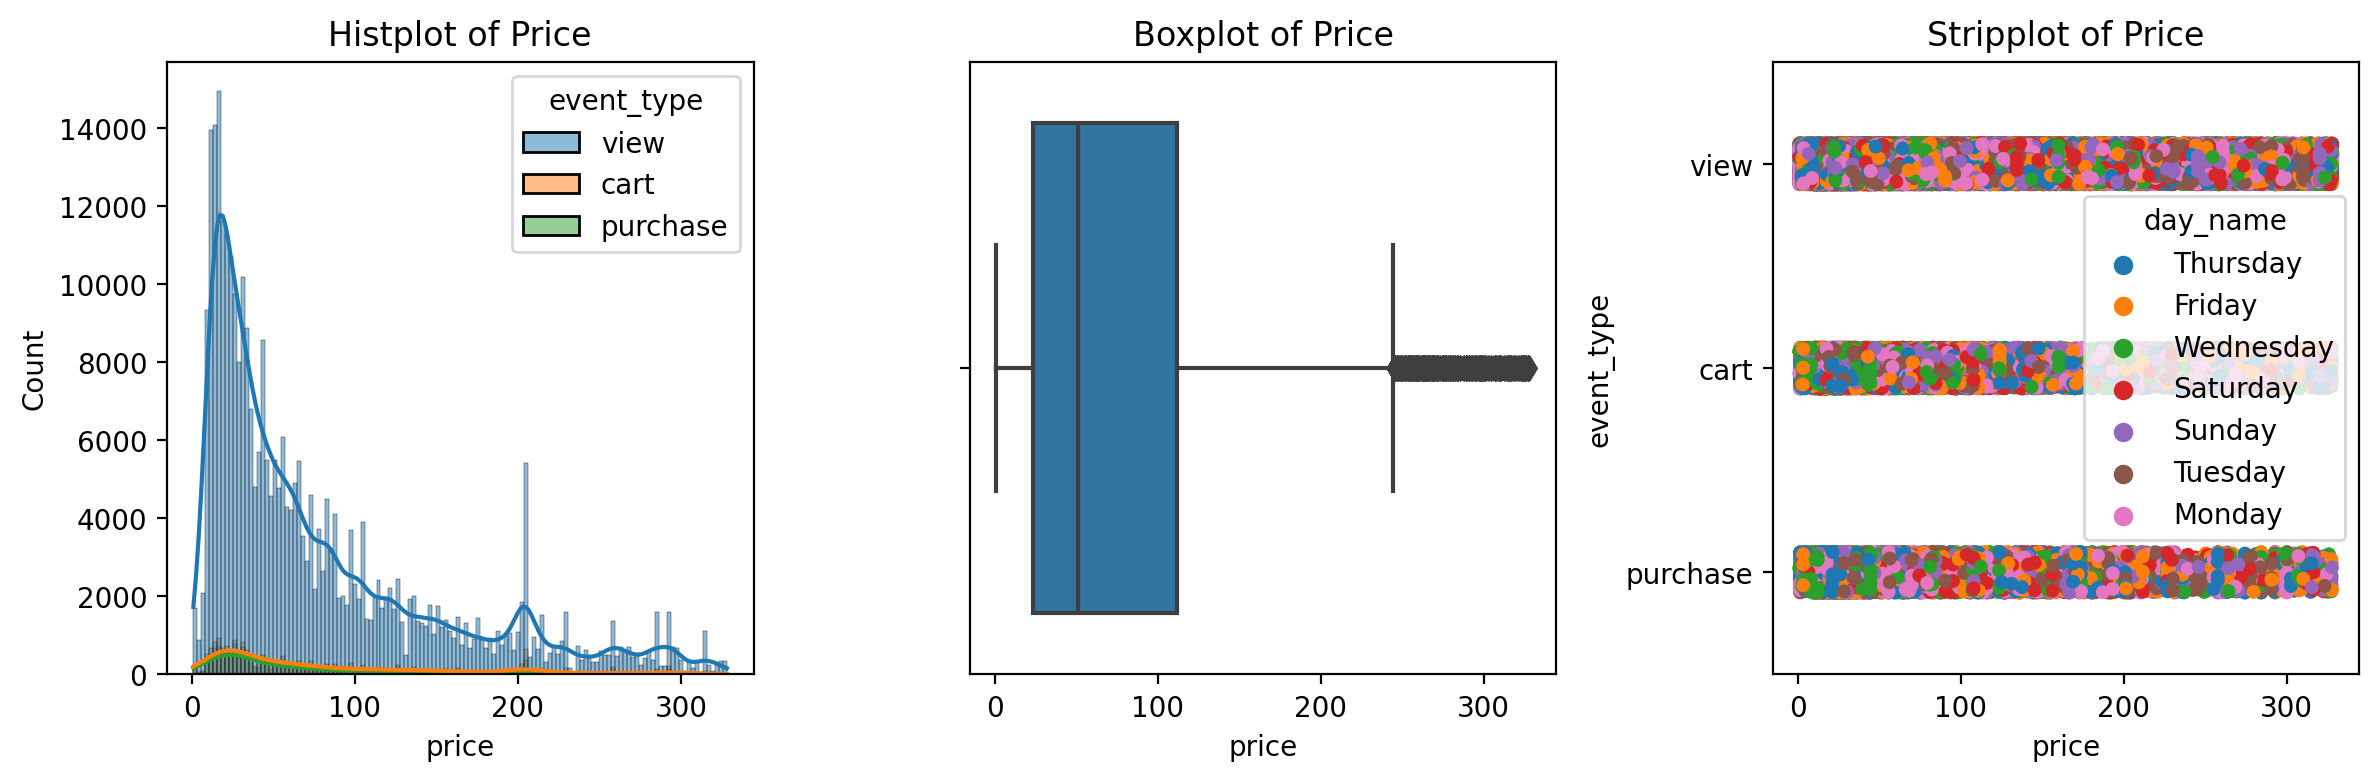

In [30]:
nrows, ncols = 1, 3
_, axes = plt.subplots(nrows, ncols, figsize=(12, 4))

p1 = sns.histplot(data=IQR_df, x="price", kde=True, hue="event_type", ax=axes[0])
p2 = sns.boxplot(data=IQR_df, x="price", hue="event_type", ax=axes[1])
# p3 = sns.stripplot(data=IQR_df, x="event_type", y="price", hue="day_name", ax=axes[2])
p3 = sns.stripplot(data=IQR_df, x="price", y="event_type", hue="day_name", ax=axes[2])

p1.set_title("Histplot of Price")
p2.set_title("Boxplot of Price")
p3.set_title("Stripplot of Price")

plt.tight_layout()
plt.show()

## event_type 분석

### event_type 분포

In [31]:
# event_type 분포
plt.figure(figsize=(10, 5))
cnt = sns.countplot(x=df_copy2["event_type"])
plt.show()

NameError: name 'df_copy2' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
df_copy2["event_type"].value_counts(normalize=True)

event_type
view        0.902370
cart        0.056951
purchase    0.040679
Name: proportion, dtype: float64

### 요일별 고객 행동 분석

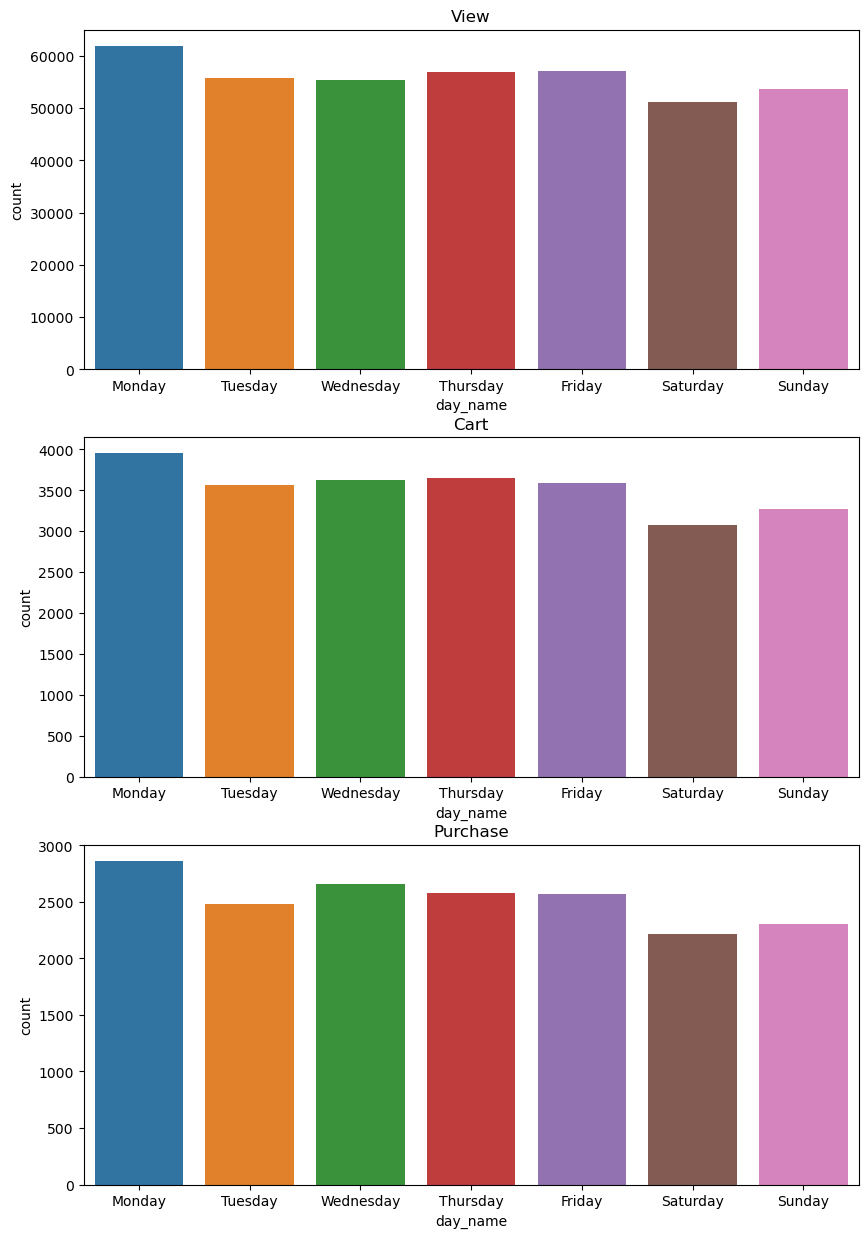

In [ ]:
# 상품 클릭, 장바구니, 구매 조건 설정
view_cond = (df_copy2["event_type"] == "view")
cart_cond = (df_copy2["event_type"] == "cart")
purchase_cond = (df_copy2["event_type"] == "purchase")

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_cnt = sns.countplot(x=df_copy2[view_cond]["day_name"],
                         order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],              
                         ax=ax[0])
view_cnt.set_title("View")

# 요일별 장바구니에 넣은 숫자
cart_cnt = sns.countplot(x=df_copy2[cart_cond]["day_name"],
                         order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                         ax=ax[1])
cart_cnt.set_title("Cart")

# 요일별 구매한 숫자
purchase_cnt = sns.countplot(x=df_copy2[purchase_cond]["day_name"],
                             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                             ax=ax[2])
purchase_cnt.set_title("Purchase")

plt.show()

### 시간대별 고객 행동 시각화

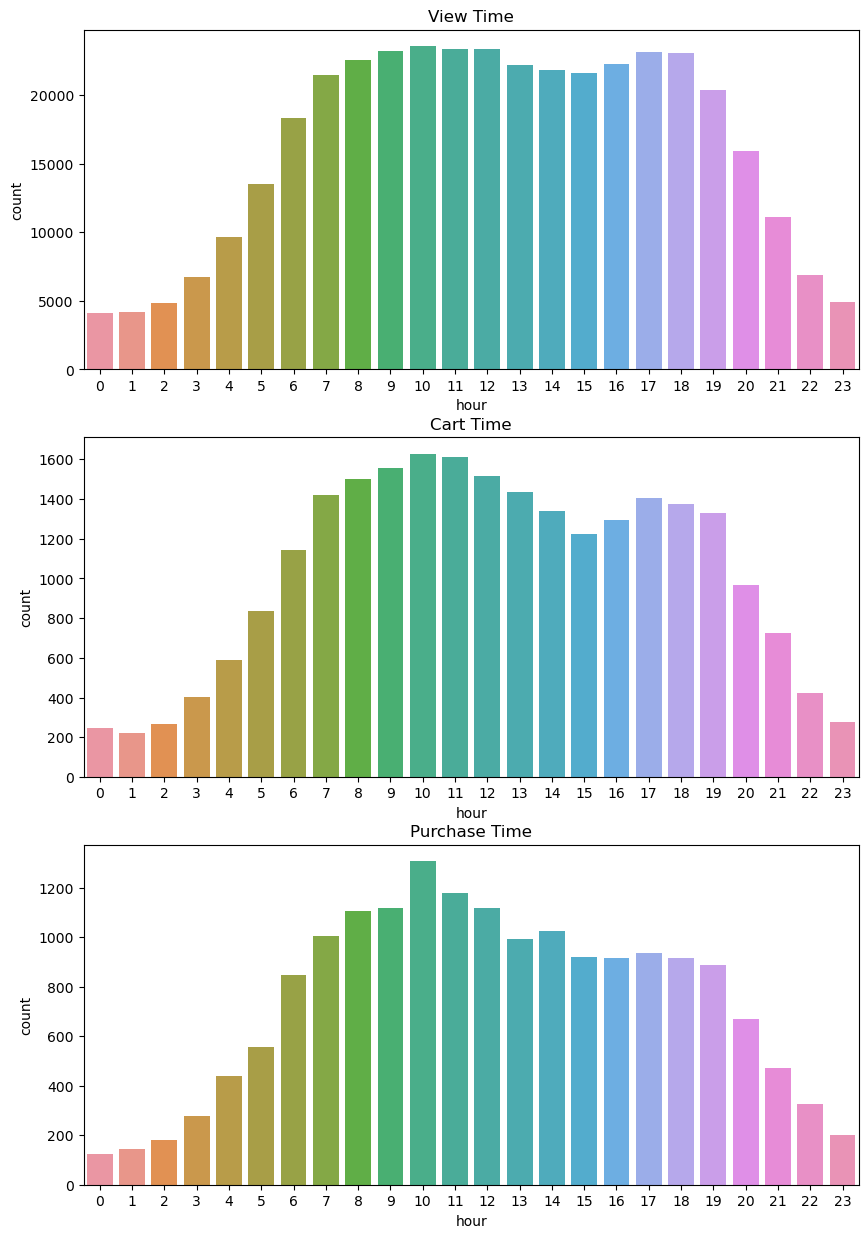

In [ ]:
# 시간대별 View, Cart, Purchase

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 시간별 상품 클릭한 숫자
view_time_cnt = sns.countplot(x=df_copy2[view_cond]["hour"],
                              ax=ax[0])
view_time_cnt.set_title("View Time")

# 시간별 장바구니에 넣은 숫자
cart_time_cnt = sns.countplot(x=df_copy2[cart_cond]["hour"],
                         ax=ax[1])
cart_time_cnt.set_title("Cart Time")

# 시간별 구매한 숫자
purchase_time_cnt = sns.countplot(x=df_copy2[purchase_cond]["hour"],
                             ax=ax[2])
purchase_time_cnt.set_title("Purchase Time")

plt.show()

### 구매전환율 (CVR, Conversion Rate) 구하기
- 사이트에 들어온 방문자가 실제 구매 활동을 하는 비율
- 구매전환율 = 전환수(구매횟수)/클릭수*100

In [ ]:
df_heat = df_copy2.copy()
# df_heat['event_time'] =  df_heat['event_time'].dt.to_period('D')

df_view_cvr = df_heat.loc[df_heat['event_type']=='view']
df_view_cvr = df_view_cvr[['event_time','user_session','price']]

df_pur_cvr = df_heat.loc[df_heat['event_type']=='purchase']
df_pur_cvr = df_pur_cvr[['event_time','user_session','price']]

In [ ]:
# view
df_date_view = df_view_cvr.groupby('event_time').count().reset_index()
# purchase
df_date_purchase = df_pur_cvr.groupby('event_time').count().reset_index()

# merge
df_cvr = pd.merge(df_date_view,df_date_purchase, on='event_time')


# cvr 컬럼추가
df_cvr['CVR'] = df_cvr['user_session_y']/df_cvr['user_session_x'] *100

In [ ]:
# 일별 매출
df_day_purchase = df_heat.loc[df_heat['event_type']=='purchase']
df_day_purchase['event_time'] =  df_day_purchase['event_time']

df_day_purchase = df_day_purchase[['event_time','price']]
df_day_purchase = df_day_purchase.groupby('event_time').sum().reset_index()

# merge

df_cvr = pd.merge(df_cvr,df_day_purchase, on='event_time')

df_cvr['weekday'] = df_cvr['event_time'].dt.weekday
df_cvr

C:\Users\IO\AppData\Local\Temp\ipykernel_8540\4292615488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day_purchase['event_time'] =  df_day_purchase['event_time']


,event_time,user_session_x,price_x,user_session_y,price_y,CVR,price,weekday
0,2020-09-24 12:49:24+00:00,1,1,1,1,100.0,36.03,3
1,2020-09-24 12:49:46+00:00,1,1,1,1,100.0,123.35,3
2,2020-09-24 15:48:48+00:00,1,1,1,1,100.0,23.48,3
3,2020-09-24 16:15:43+00:00,1,1,1,1,100.0,59.54,3
4,2020-09-25 06:54:46+00:00,1,1,1,1,100.0,251.92,4
...,...,...,...,...,...,...,...,...
1061,2020-12-21 14:22:06+00:00,1,1,2,2,200.0,139.77,0
1062,2020-12-21 16:46:06+00:00,1,1,1,1,100.0,482.52,0
1063,2020-12-21 18:01:56+00:00,1,1,1,1,100.0,10.48,0
1064,2020-12-21 18:55:49+00:00,1,1,1,1,100.0,370.46,0


#### 일일 매출, CVR 시각화

Text(0.5, 1.0, 'Daily CVR')

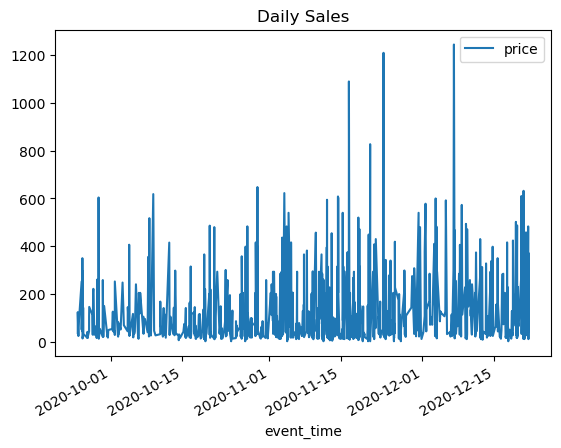

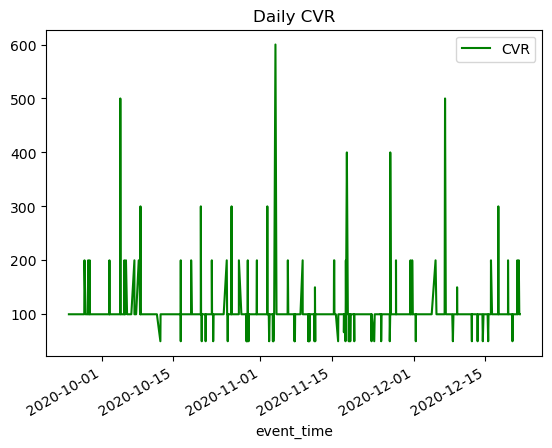

In [ ]:
# 일일 매출, CVR 시각화

sales_line = df_cvr.plot(x="event_time", y="price")
sales_line.set_title("Daily Sales")

cvr_line = df_cvr.plot(x="event_time", y="CVR", color="green")
cvr_line.set_title("Daily CVR")

## 생각해볼 것
- 고객 행동 분석
    - 전체적으로 월요일에 view, cart, purchase 횟수가 많다
        - 월요일에 특정 Action Plan 가져갈 수 있을까?
    - 시간대별 그래프도 view, cart, purchase 거의 비슷한 양상이지만, 17시 ~ 19시 사이 그래프 모양이 좀 다르다
        - purchase 오전 10시에 높지만, view, cart에 비해 17시 ~ 19시는 낮다

## 추가 진행 요소
- 결측치 처리 방법
- CVR 다시 구해보기
- 퍼널, 코호트 분석
